In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import StatevectorSimulator, AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.quantum_info import SparsePauliOp, DensityMatrix, partial_trace
import numpy as np
from scipy.linalg import expm, block_diag
import matplotlib.pyplot as plt
from qiskit.circuit.library import QFT, XGate
from qiskit.extensions import UnitaryGate, HamiltonianGate
from qiskit.circuit.random import random_circuit

In [2]:
EPS = 1
FRAMES = 30
n_logics = 3

def make_ising_hamiltonian(h_k:np.ndarray, J_ij:np.ndarray):
    assert h_k.shape[0] == J_ij.shape[0] == J_ij.shape[1]
    N = len(h_k)
    pauli_lists = []
    coeffs = []
    for k, h in enumerate(h_k):
        _string = ['I']*N
        _string[k] = 'Z'
        pauli_lists.append(''.join(_string))
        coeffs.append(h)

    for i in range(N):
        for j in range(i+1, N):
            _string = ['I']*N
            _string[i] = 'X'
            _string[j] = 'X'
            pauli_lists.append(''.join(_string))
            coeffs.append(J_ij[i, j])
    
    return SparsePauliOp(data=pauli_lists, coeffs=coeffs)

hamiltonian = make_ising_hamiltonian(1*np.ones(n_logics+1), 0.01*np.ones((n_logics+1, n_logics+1)))

reset = DensityMatrix(np.array([[np.exp(EPS), 0], [0, np.exp(-EPS)]])/(np.exp(EPS)+np.exp(-EPS)))
# logic = DensityMatrix(np.eye(2**n_logics)/2**n_logics)
logic = DensityMatrix.from_instruction(random_circuit(n_logics, n_logics, measure=False))
TSUnitary = UnitaryGate(block_diag(*([np.eye(1)]+[XGate().to_matrix()]*(2**n_logics-1)+[np.eye(1)])))
# TSUnitary = HamiltonianGate(data=hamiltonian, time=0.0001)

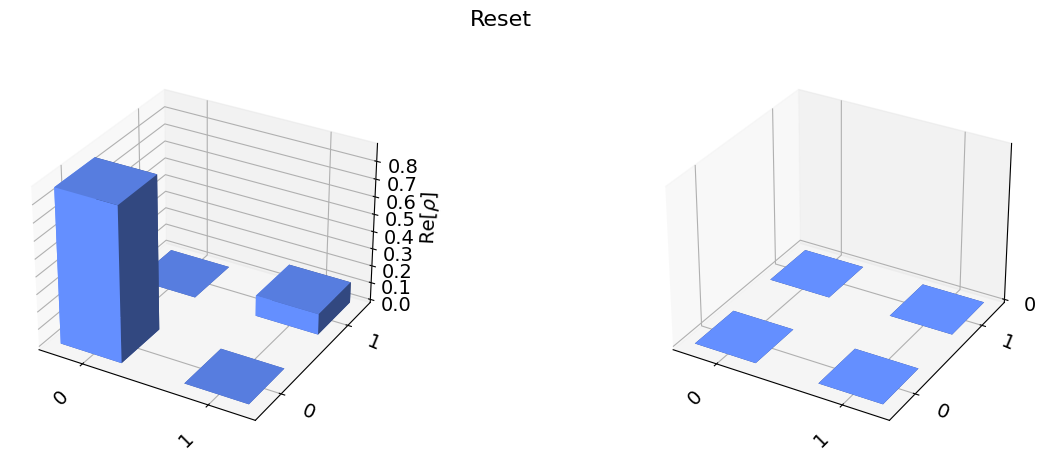

In [3]:
plot_state_city(reset, title='Reset')

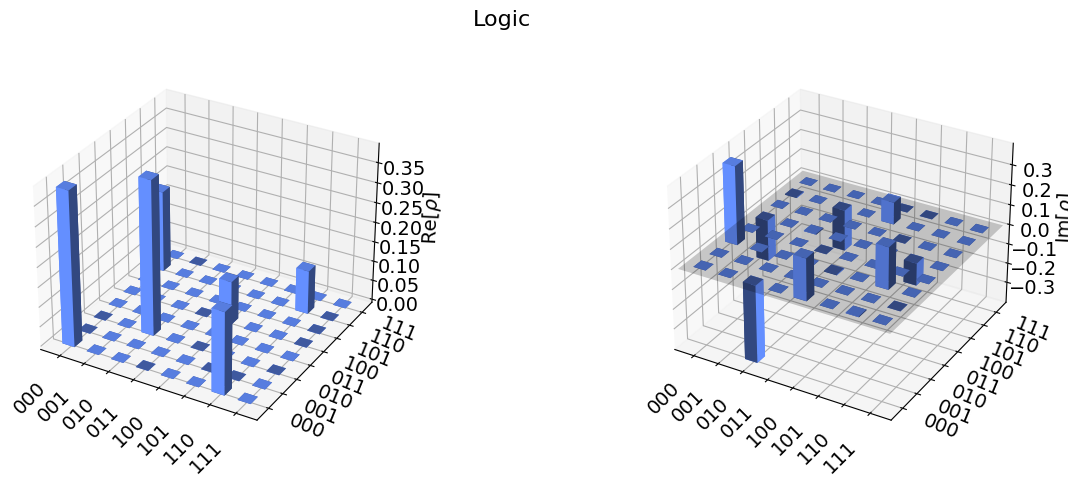

In [4]:
plot_state_city(logic, title='Logic')

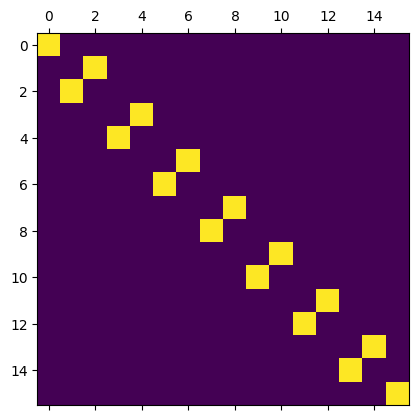

In [5]:
plt.matshow(np.real(TSUnitary.to_matrix()))

In [6]:
def qi_step(logic:DensityMatrix, unitary:UnitaryGate, reset:DensityMatrix):
    state = logic.tensor(reset)
    state = state.evolve(unitary)
    logic = partial_trace(state, [0])
    reset = partial_trace(state, range(1, state.num_qubits))
    return logic, reset

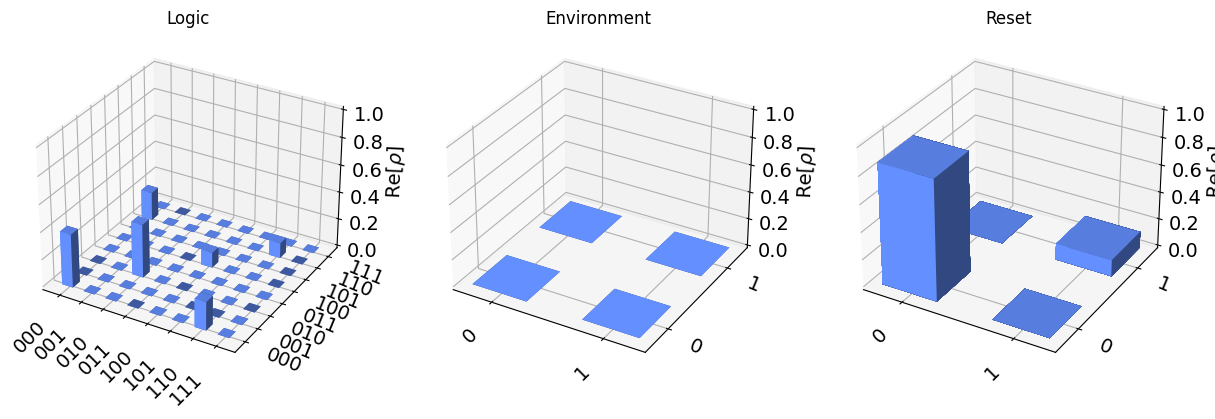

In [7]:
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax1.set_title('Logic')
ax2.set_title('Environment')
ax3.set_title('Reset')
ax1.set_zlim3d(0, 1)
ax2.set_zlim3d(0, 1)
ax3.set_zlim3d(0, 1)

plot_state_city(reset, ax_real=ax3);

logics = [logic]
envs = [DensityMatrix(np.zeros((2, 2)))]
resets = [reset]

for i in range(FRAMES):
    _logic, _reset = logics[-1], resets[-1]
    _logic, _env = qi_step(_logic, TSUnitary, _reset)
    logics.append(_logic)
    envs.append(_env)
    resets.append(_reset)

def update(frame, logics, envs, resets):
    ax1.clear()
    ax2.clear()
    plot_state_city(logics[frame], ax_real=ax1);
    plot_state_city(envs[frame], ax_real=ax2);
    plot_state_city(resets[frame], ax_real=ax3);

    ax1.set_title('Logic')
    ax2.set_title('Environment')
    ax3.set_title('Reset')
    ax1.set_zlim3d(0, 1)
    ax2.set_zlim3d(0, 1)
    ax3.set_zlim3d(0, 1)
    return ax1, ax2

ani = animation.FuncAnimation(fig, update, frames=FRAMES, fargs=(logics, envs, resets), interval=100, blit=False)
HTML(ani.to_jshtml())

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table